Task: to analyze the results of the A / B test in the context of various parameters. Versions of the page differ in the number of fields to fill out

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import fisher_exact

In [6]:
df.head()

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
0,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,7,360x640,4801472,MOB
1,Other,Other,NaN,1,old,AND,4.3,1440x1440,4790389,MOB
2,SAMSUNG,CHROME MOBILE,SMARTPHONE,1,new,AND,7,360x640,5272442,MOB
3,APPLE,MOBILE SAFARI,SMARTPHONE,1,new,IOS,11.3,414x736,5030185,MOB
4,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,7,360x640,3857978,MOB


Let's check whether user IDs are unique

In [113]:
df['idvisit'].nunique() == df.shape[0]

True

In [51]:
df['Conversion'] = df['Conversion'].replace({1: 'click', 0: 'no_click'})  
df['count'] = 1

In [44]:
table = pd.pivot_table(df, values='count', index=['Conversion'],
                    columns=['A/B'], aggfunc=np.sum)

In [45]:
table.index = table.index.to_flat_index()

In [46]:
table.columns = table.columns.get_level_values(0).astype(str)

In [47]:
table.columns = [''.join(col).strip() for col in table.columns.values]
table.index = [''.join(ind).strip() for ind in table.index.values]

Preparing data for analysis using the Fisher test

In [48]:
table

,new,old
click,340,235
no_click,1145,821


In [19]:
df_dict = {('new', 'click'): 1865, ('new', 'no_click'): 13564, ('old', 'click'): 1350, 
           ('old', 'no_click'): 9806}

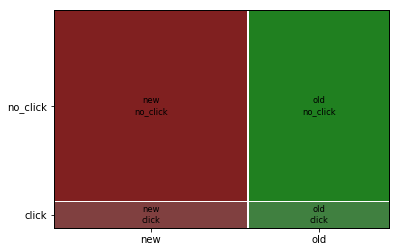

In [30]:
mosaic(df_dict)  
plt.show()

In [49]:
oddsr, p = fisher_exact(table=table.to_numpy(), alternative='two-sided')
oddsr, p

(1.037405927715321, 0.736364042948606)

p-value = 0.74. The differences are not statistically significant

In [103]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == threshold
    return ['background-color: orange' if is_max.any() else '' for v in is_max]

Now let's look at conversions in terms of different criteria

In [58]:
DEVICES_BRANDS = df.groupby(['DEVICES_BRANDS','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "click"').rename(columns = {'Conversion':'click', 'count':'count_click'})\
.merge(df.groupby(['DEVICES_BRANDS','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "no_click"').rename(columns = {'Conversion':'no_click', 'count':'count_no_click'}), how = 'inner', on = ['DEVICES_BRANDS','A/B'])

In [ ]:
DEVICES_BRANDS['conversion'] = round(DEVICES_BRANDS['count_click'] / (DEVICES_BRANDS['count_click'] +  DEVICES_BRANDS['count_no_click']) * 100, 2)

In [104]:
DEVICES_BRANDS.style.apply(highlight_greaterthan, threshold="HUAWEI", column=['DEVICES_BRANDS'], axis=1)

,DEVICES_BRANDS,A/B,click,count_click,no_click,count_no_click,conversion
0,APPLE,new,click,340,no_click,1145,22.900000
1,APPLE,old,click,235,no_click,821,22.250000
2,HUAWEI,new,click,32,no_click,198,13.910000
3,HUAWEI,old,click,16,no_click,170,8.600000
4,Other,new,click,1161,no_click,9910,10.490000
5,Other,old,click,867,no_click,7101,10.880000
6,SAMSUNG,new,click,332,no_click,2311,12.560000
7,SAMSUNG,old,click,232,no_click,1714,11.920000


We see that the conversions are different on the "HUAWEI" device. To check statistical significance, we will again use Fisher's test

In [117]:
HUAWEI = pd.pivot_table(df.query('DEVICES_BRANDS == "HUAWEI"'), values='count', index=['Conversion'],
                    columns=['A/B'], aggfunc=np.sum)
HUAWEI.index = HUAWEI.index.to_flat_index()
HUAWEI.columns = HUAWEI.columns.get_level_values(0).astype(str)
HUAWEI.columns = [''.join(col).strip() for col in HUAWEI.columns.values]
HUAWEI.index = [''.join(ind).strip() for ind in HUAWEI.index.values]

In [119]:
oddsr, p = fisher_exact(table=HUAWEI.to_numpy(), alternative='two-sided')
oddsr, p

(1.7171717171717171, 0.12207182806368072)

p-value = 0.12. The differences are not statistically significant

In [64]:
BROWSERS = df.groupby(['BROWSERS','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "click"').rename(columns = {'Conversion':'click', 'count':'count_click'})\
.merge(df.groupby(['BROWSERS','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "no_click"').rename(columns = {'Conversion':'no_click', 'count':'count_no_click'}), how = 'inner', on = ['BROWSERS','A/B'])

In [66]:
BROWSERS['conversion'] = round(BROWSERS['count_click'] / (BROWSERS['count_click'] +  BROWSERS['count_no_click']) * 100, 2)

In [88]:
BROWSERS.style.apply(highlight_greaterthan, threshold = "FIREFOX", column=['BROWSERS'], axis=1)

,BROWSERS,A/B,click,count_click,no_click,count_no_click,conversion
0,CHROME,new,click,324,no_click,1133,22.240000
1,CHROME,old,click,236,no_click,941,20.050000
2,CHROME MOBILE,new,click,1057,no_click,10689,9.000000
3,CHROME MOBILE,old,click,790,no_click,7535,9.490000
4,FIREFOX,new,click,95,no_click,298,24.170000
5,FIREFOX,old,click,46,no_click,252,15.440000
6,MOBILE SAFARI,new,click,329,no_click,1099,23.040000
7,MOBILE SAFARI,old,click,223,no_click,789,22.040000
8,Other,new,click,60,no_click,345,14.810000
9,Other,old,click,55,no_click,289,15.990000


We see that y browsers "FIREFOX" conversions are different. To check statistical significance, we will again use Fisher's test

In [123]:
FIREFOX = pd.pivot_table(df.query('BROWSERS == "FIREFOX"'), values='count', index=['Conversion'],
                    columns=['A/B'], aggfunc=np.sum)
FIREFOX.index = FIREFOX.index.to_flat_index()
FIREFOX.columns = FIREFOX.columns.get_level_values(0).astype(str)
FIREFOX.columns = [''.join(col).strip() for col in FIREFOX.columns.values]
FIREFOX.index = [''.join(ind).strip() for ind in FIREFOX.index.values]

In [125]:
oddsr, p = fisher_exact(table=FIREFOX.to_numpy(), alternative='two-sided')
oddsr, p

(1.746425444995623, 0.005601489016567228)

p-value = 0.005. The gender differences are significant

In [91]:
DEVICE_TYPE = df.groupby(['DEVICE_TYPE','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "click"').rename(columns = {'Conversion':'click', 'count':'count_click'})\
.merge(df.groupby(['DEVICE_TYPE','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "no_click"').rename(columns = {'Conversion':'no_click', 'count':'count_no_click'}), how = 'inner', on = ['DEVICE_TYPE','A/B'])

In [92]:
DEVICE_TYPE['conversion'] = round(DEVICE_TYPE['count_click'] / (DEVICE_TYPE['count_click'] +  DEVICE_TYPE['count_no_click']) * 100, 2)

In [94]:
DEVICE_TYPE.style.apply(highlight_greaterthan, threshold = "DESKTOP", column=['DEVICE_TYPE'], axis=1)

,DEVICE_TYPE,A/B,click,count_click,no_click,count_no_click,conversion
0,DESKTOP,new,click,380,no_click,1172,24.480000
1,DESKTOP,old,click,253,no_click,979,20.540000
2,PHABLET,new,click,39,no_click,284,12.070000
3,PHABLET,old,click,33,no_click,228,12.640000
4,SMARTPHONE,new,click,1404,no_click,11869,10.580000
5,SMARTPHONE,old,click,1025,no_click,8404,10.870000
6,TABLET,new,click,36,no_click,181,16.590000
7,TABLET,old,click,38,no_click,152,20.000000


We see that the conversions are different on the "DESKTOP" device. To check statistical significance, we will again use Fisher's test

In [128]:
DESKTOP = pd.pivot_table(df.query('DEVICE_TYPE == "DESKTOP"'), values='count', index=['Conversion'],
                    columns=['A/B'], aggfunc=np.sum)
DESKTOP.index = DESKTOP.index.to_flat_index()
DESKTOP.columns = DESKTOP.columns.get_level_values(0).astype(str)
DESKTOP.columns = [''.join(col).strip() for col in DESKTOP.columns.values]
DESKTOP.index = [''.join(ind).strip() for ind in DESKTOP.index.values]

In [129]:
oddsr, p = fisher_exact(table=DESKTOP.to_numpy(), alternative='two-sided')
oddsr, p

(1.254637186526191, 0.013976257223016791)

p-value = 0.01. The differences are not statistically significant

In [96]:
config_os = df.groupby(['config_os','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "click"').rename(columns = {'Conversion':'click', 'count':'count_click'})\
.merge(df.groupby(['config_os','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "no_click"').rename(columns = {'Conversion':'no_click', 'count':'count_no_click'}), how = 'inner', on = ['config_os','A/B'])

In [97]:
config_os['conversion'] = round(config_os['count_click'] / (config_os['count_click'] +  config_os['count_no_click']) * 100, 2)

In [105]:
config_os.style.apply(highlight_greaterthan, threshold = "WIN", column=['config_os'], axis=1)

,config_os,A/B,click,count_click,no_click,count_no_click,conversion
0,AND,new,click,1144,no_click,11210,9.260000
1,AND,old,click,862,no_click,7946,9.790000
2,IOS,new,click,340,no_click,1145,22.900000
3,IOS,old,click,235,no_click,821,22.250000
4,LIN,new,click,4,no_click,9,30.770000
5,LIN,old,click,1,no_click,15,6.250000
6,MAC,new,click,25,no_click,60,29.410000
7,MAC,old,click,25,no_click,54,31.650000
8,UBT,new,click,2,no_click,1,66.670000
9,UNK,new,click,1,no_click,17,5.560000


We see that the os "WIN" conversions are different. To check statistical significance, we will again use Fisher's test

In [140]:
WIN = pd.pivot_table(df.query('config_os == "WIN"'), values='count', index=['Conversion'],
                    columns=['A/B'], aggfunc=np.sum)
WIN.index = WIN.index.to_flat_index()
WIN.columns = WIN.columns.get_level_values(0).astype(str)
WIN.columns = [''.join(col).strip() for col in WIN.columns.values]
WIN.index = [''.join(ind).strip() for ind in WIN.index.values]

In [141]:
oddsr, p = fisher_exact(table=WIN.to_numpy(), alternative='two-sided')
oddsr, p

(1.2711600319654324, 0.013256865433701658)

p-value = 0.01. The differences are not statistically significant

In [109]:
platform_v4 = df.groupby(['platform_v4','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "click"').rename(columns = {'Conversion':'click', 'count':'count_click'})\
.merge(df.groupby(['platform_v4','A/B','Conversion'], as_index = False).agg({'count':'count'}).query('Conversion == "no_click"').rename(columns = {'Conversion':'no_click', 'count':'count_no_click'}), how = 'inner', on = ['platform_v4','A/B'])

In [110]:
platform_v4['conversion'] = round(platform_v4['count_click'] / (platform_v4['count_click'] +  platform_v4['count_no_click']) * 100, 2)

In [112]:
platform_v4.style.apply(highlight_greaterthan, threshold = "WEB", column=['platform_v4'], axis=1)

,platform_v4,A/B,click,count_click,no_click,count_no_click,conversion
0,MOB,new,click,1446,no_click,12133,10.650000
1,MOB,old,click,1068,no_click,8613,11.030000
2,WEB,new,click,419,no_click,1431,22.650000
3,WEB,old,click,282,no_click,1193,19.120000


We see that on "WEB" conversions are different. To check statistical significance, we will again use Fisher's test

In [136]:
WEB = pd.pivot_table(df.query('platform_v4 == "WEB"'), values='count', index=['Conversion'],
                    columns=['A/B'], aggfunc=np.sum)
WEB.index = WEB.index.to_flat_index()
WEB.columns = WEB.columns.get_level_values(0).astype(str)
WEB.columns = [''.join(col).strip() for col in WEB.columns.values]
WEB.index = [''.join(ind).strip() for ind in WEB.index.values]

In [137]:
oddsr, p = fisher_exact(table=WEB.to_numpy(), alternative='two-sided')
oddsr, p

(1.238698821931794, 0.013118342618191635)

p-value = 0.01. The differences are not statistically significant

A comparison of the total conversion yielded no results, the conversions are practically the same in the new and old versions.
 No statistically significant differences were found either. The comparison was carried out using Fisher's test, as a result we received a pvalue = 0.73, which is not statistically significant.
A closer look revealed that only one browser, FIREFOX, had statistically significant differences. This could happen, for example, due to the fact that auto-filling of forms did not work in the browser during the test period (Firefox was the first among all browsers and most fully implemented the support of Enhanced Cookie Clearing as part of the general protection of Total Cookie Protection). Most likely, other users had the form autofill working fine and they didn't even notice the changes